## load cadana database

In [61]:
import pandas

canada_db = pandas.read_csv('./data/ds_canada/2. SOC_Database.csv')

canada_db

,SampleID,SOC (%),Catch,Conv,Elev,DevME A,DevME B,DevME C,DevME D,DiffME A,...,TPI,TRI,TWI,VDepth,VIS,NDVI_max,NDVI_median,NDVI_sd,X (DD),Y (DD)
0,1,4.88,105.560303,-1.695651,397.309113,-0.242336,-0.019693,-0.416003,-1.223508,-0.042645,...,-0.025165,0.059154,8.648174,9.705094,98.230995,0.876076,0.694713,0.164614,-80.269163,43.707232
1,2,4.76,11756.406250,-12.779182,397.207977,-0.778743,-0.452079,-0.494462,-1.258175,-0.106777,...,-0.180933,0.021448,14.400584,10.325721,98.319786,0.915627,0.613926,0.210947,-80.269013,43.707365
2,3,5.10,2824.329590,-0.521328,397.390015,-0.171732,-0.254896,-0.437166,-1.231417,-0.031157,...,-0.111542,0.037374,12.385666,9.450062,98.371185,0.927210,0.646960,0.234737,-80.268867,43.707490
3,4,5.70,5295.354492,3.123698,397.513275,0.009115,0.044004,-0.394856,-1.225852,0.001653,...,0.000611,0.031468,13.188428,8.735661,98.379845,0.915750,0.711604,0.183207,-80.268703,43.707638
4,5,5.11,6871.969727,2.661578,397.637207,0.072724,0.113439,-0.366388,-1.215629,0.014545,...,0.057567,0.041576,13.167877,8.526403,98.394020,0.934996,0.651558,0.271645,-80.268508,43.707771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,836,1.63,169.625778,1.168782,405.551361,-0.013676,0.177649,0.746808,0.316329,-0.018182,...,1.307380,0.284868,7.540807,1.685164,97.465759,0.946501,0.601615,0.312782,-80.264381,43.709098
836,837,1.62,194.982132,1.109466,405.171936,-0.065693,0.059607,0.636818,0.236880,-0.084876,...,1.002432,0.262172,7.763628,1.950791,97.504158,0.946501,0.601615,0.312782,-80.264391,43.709108
837,838,2.33,294.323792,-2.423489,406.557678,-0.013564,0.094944,0.645256,0.449286,-0.011240,...,0.749751,0.170413,8.605540,1.151467,98.159378,0.947470,0.568452,0.311198,-80.264912,43.708098
838,839,2.98,147.879089,0.184841,407.262115,0.085817,0.238642,0.888877,0.602132,0.086281,...,1.152760,0.229932,7.618076,0.967014,98.149689,0.947902,0.615135,0.303823,-80.264641,43.708298


## adding satellite image data

In [62]:
import rasterio

raster = rasterio.open("./data/sentinel_images/eca6374937ae5f499c4b13e5c83a08f6/response.tiff")

print(raster.count)
print(raster.shape)

min_x_gps, min_y_gps = raster.xy(0, 0)
max_x_gps, max_y_gps = raster.xy(raster.shape[0], raster.shape[1])

print(min_x_gps, min_y_gps)
print(max_x_gps, max_y_gps)

13
(2378, 1993)
-80.26999749121926 43.71249821278385
-80.25999749121927 43.70399821278385


In [63]:
from scipy.interpolate import interp1d

from_gps_to_raster_x = interp1d([min_x_gps, max_x_gps], [0, raster.shape[0]])
from_gps_to_raster_y = interp1d([min_y_gps, max_y_gps], [0, raster.shape[1]])

def add_column_by_band(band, band_name):
    values = []
    for j in canada_db.index:
        x = canada_db['X (DD)'].iloc[j]
        y = canada_db['Y (DD)'].iloc[j]
        x_raster = round(float(from_gps_to_raster_x(x)))
        y_raster = round(float(from_gps_to_raster_y(y)))
        value = band[x_raster][y_raster]
        values.append(value)
    canada_db[band_name] = values

for i in range(1, raster.count + 1):
    band = raster.read(i)
    add_column_by_band(band, "band_" + str(i))

# adding ndvi
band_red = raster.read(4)
band_nir = raster.read(8)
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)
add_column_by_band(ndvi, "ndvi")

raster.close()

canada_db

,SampleID,SOC (%),Catch,Conv,Elev,DevME A,DevME B,DevME C,DevME D,DiffME A,...,band_5,band_6,band_7,band_8,band_9,band_10,band_11,band_12,band_13,ndvi
0,1,4.88,105.560303,-1.695651,397.309113,-0.242336,-0.019693,-0.416003,-1.223508,-0.042645,...,762,2349,3349,3167,3641,947,9,1557,637,0.721663
1,2,4.76,11756.406250,-12.779182,397.207977,-0.778743,-0.452079,-0.494462,-1.258175,-0.106777,...,739,2374,3401,3170,3800,947,9,1507,614,0.718623
2,3,5.10,2824.329590,-0.521328,397.390015,-0.171732,-0.254896,-0.437166,-1.231417,-0.031157,...,742,2437,3565,3258,3902,947,9,1514,605,0.721987
3,4,5.70,5295.354492,3.123698,397.513275,0.009115,0.044004,-0.394856,-1.225852,0.001653,...,724,2471,3660,3380,3966,947,9,1504,587,0.732445
4,5,5.11,6871.969727,2.661578,397.637207,0.072724,0.113439,-0.366388,-1.215629,0.014545,...,695,2536,3965,3854,4326,1005,9,1524,577,0.771954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,836,1.63,169.625778,1.168782,405.551361,-0.013676,0.177649,0.746808,0.316329,-0.018182,...,735,2522,3783,3708,4161,992,11,1569,618,0.752777
836,837,1.62,194.982132,1.109466,405.171936,-0.065693,0.059607,0.636818,0.236880,-0.084876,...,735,2522,3783,3708,4161,992,11,1569,618,0.752777
837,838,2.33,294.323792,-2.423489,406.557678,-0.013564,0.094944,0.645256,0.449286,-0.011240,...,722,2429,3623,3556,3916,948,10,1515,613,0.743137
838,839,2.98,147.879089,0.184841,407.262115,0.085817,0.238642,0.888877,0.602132,0.086281,...,731,2434,3595,3466,3900,962,11,1510,600,0.740834


## adding hwsd data

In [64]:
import rasterio

raster = rasterio.open("./data/fao/hwsd/HWSD_RASTER/hwsd.bil").read(1)

print(raster.shape)

(21600, 43200)


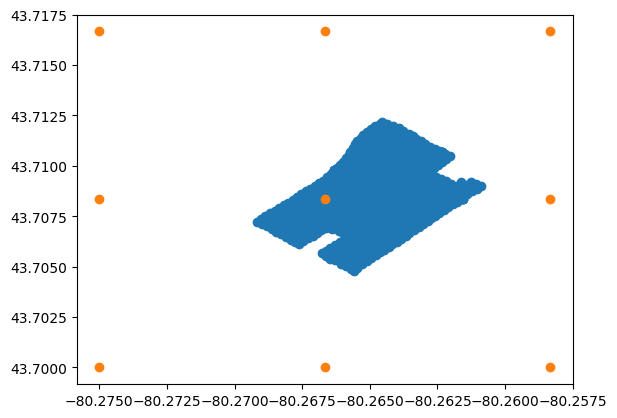

In [65]:
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import math

from_raster_to_gps_i = interp1d([0, raster.shape[0]], [90, -90])
from_raster_to_gps_j = interp1d([0, raster.shape[1]], [-180, 180])
from_gps_to_raster_i = interp1d([90, -90], [0, raster.shape[0]])
from_gps_to_raster_j = interp1d([-180, 180], [0, raster.shape[1]])

points = set()

for index in canada_db.index:
    x = float(canada_db['X (DD)'].iloc[index])
    y = float(canada_db['Y (DD)'].iloc[index])

    x_raster = from_gps_to_raster_j(x)
    y_raster = from_gps_to_raster_i(y)

    x_raster_down = math.floor(x_raster)
    x_raster_up = math.ceil(x_raster)

    y_raster_down = math.floor(y_raster)
    y_raster_up = math.ceil(y_raster)

    points.add((x_raster_down, y_raster_down))
    points.add((x_raster_down, y_raster_up))
    points.add((x_raster_up, y_raster_down))
    points.add((x_raster_up, y_raster_up))

x = [from_raster_to_gps_j(elem[0]) for elem in points]
y = [from_raster_to_gps_i(elem[1]) for elem in points]

plt.scatter(canada_db['X (DD)'], canada_db['Y (DD)'])
plt.scatter(x, y)

In [66]:
import pyodbc
import pandas

MDB = './data/fao/hwsd/HWSD.mdb'
DRV = '{Microsoft Access Driver (*.mdb, *.accdb)}'

con = pyodbc.connect('DRIVER={};DBQ={}'.format(DRV,MDB))
cur = con.cursor()
rows = cur.execute('SELECT * FROM HWSD_DATA;').fetchall()

columns = [column[0] for column in cur.description]

cur.close()
con.close()

df = pandas.DataFrame((tuple(t) for t in rows))
df.columns = columns

df

,ID,MU_GLOBAL,MU_SOURCE1,MU_SOURCE2,ISSOIL,SHARE,SEQ,SU_SYM74,SU_CODE74,SU_SYM85,...,S_OC,S_PH_H2O,S_CEC_CLAY,S_CEC_SOIL,S_BS,S_TEB,S_CACO3,S_CASO4,S_ESP,S_ECE
0,2,7002,2,2.0,0,100.0,1,None,NaN,HD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,7003,3,3.0,0,100.0,1,None,NaN,WR,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,7004,4,4.0,0,100.0,1,None,NaN,Od,...,32.89,4.6,71.0,78.0,40.0,27.4,0.0,0.0,1.0,0.1
3,5,7005,5,5.0,0,100.0,1,None,NaN,GG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,7006,70001,70001.0,1,70.0,1,None,NaN,Tv,...,1.85,5.9,146.0,10.0,23.0,5.3,0.0,0.0,1.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48143,48145,32049,TN249,NaN,1,20.0,4,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48144,48146,32050,TN250,NaN,1,50.0,1,None,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48145,48147,32050,TN250,NaN,1,30.0,2,None,NaN,None,...,0.13,8.5,37.0,3.0,100.0,3.1,5.7,0.1,4.0,1.0
48146,48148,32050,TN250,NaN,1,20.0,3,None,NaN,None,...,0.18,8.7,27.0,4.0,90.0,3.6,3.0,0.2,2.0,0.1


In [67]:
mp = pandas.DataFrame(columns = columns)

for point in points:
    rows = df[df['MU_GLOBAL'] == raster[point[1]][point[0]]]
    mp = pandas.concat([mp, rows])

mp.drop_duplicates(inplace=True)
mp

C:\Users\EBELLIMTP\AppData\Local\Temp\ipykernel_10172\1326168294.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mp = pandas.concat([mp, rows])


,ID,MU_GLOBAL,MU_SOURCE1,MU_SOURCE2,ISSOIL,SHARE,SEQ,SU_SYM74,SU_CODE74,SU_SYM85,...,S_OC,S_PH_H2O,S_CEC_CLAY,S_CEC_SOIL,S_BS,S_TEB,S_CACO3,S_CASO4,S_ESP,S_ECE
43970,43972,4847,4847,NaN,1,100.0,1,La,83.0,None,...,0.39,6.3,56.0,21.0,89.0,18.1,0.0,0.0,1.0,0.1


In [68]:
selected_columns = mp.columns[23:] # filter columns

for column in selected_columns:
    canada_db[column] = [mp[column].iloc[0]] * len(canada_db.index)

canada_db

,SampleID,SOC (%),Catch,Conv,Elev,DevME A,DevME B,DevME C,DevME D,DiffME A,...,S_OC,S_PH_H2O,S_CEC_CLAY,S_CEC_SOIL,S_BS,S_TEB,S_CACO3,S_CASO4,S_ESP,S_ECE
0,1,4.88,105.560303,-1.695651,397.309113,-0.242336,-0.019693,-0.416003,-1.223508,-0.042645,...,0.39,6.3,56.0,21.0,89.0,18.1,0.0,0.0,1.0,0.1
1,2,4.76,11756.406250,-12.779182,397.207977,-0.778743,-0.452079,-0.494462,-1.258175,-0.106777,...,0.39,6.3,56.0,21.0,89.0,18.1,0.0,0.0,1.0,0.1
2,3,5.10,2824.329590,-0.521328,397.390015,-0.171732,-0.254896,-0.437166,-1.231417,-0.031157,...,0.39,6.3,56.0,21.0,89.0,18.1,0.0,0.0,1.0,0.1
3,4,5.70,5295.354492,3.123698,397.513275,0.009115,0.044004,-0.394856,-1.225852,0.001653,...,0.39,6.3,56.0,21.0,89.0,18.1,0.0,0.0,1.0,0.1
4,5,5.11,6871.969727,2.661578,397.637207,0.072724,0.113439,-0.366388,-1.215629,0.014545,...,0.39,6.3,56.0,21.0,89.0,18.1,0.0,0.0,1.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,836,1.63,169.625778,1.168782,405.551361,-0.013676,0.177649,0.746808,0.316329,-0.018182,...,0.39,6.3,56.0,21.0,89.0,18.1,0.0,0.0,1.0,0.1
836,837,1.62,194.982132,1.109466,405.171936,-0.065693,0.059607,0.636818,0.236880,-0.084876,...,0.39,6.3,56.0,21.0,89.0,18.1,0.0,0.0,1.0,0.1
837,838,2.33,294.323792,-2.423489,406.557678,-0.013564,0.094944,0.645256,0.449286,-0.011240,...,0.39,6.3,56.0,21.0,89.0,18.1,0.0,0.0,1.0,0.1
838,839,2.98,147.879089,0.184841,407.262115,0.085817,0.238642,0.888877,0.602132,0.086281,...,0.39,6.3,56.0,21.0,89.0,18.1,0.0,0.0,1.0,0.1


In [69]:
canada_db.to_csv("./data/dataset.csv", index=False)